In [8]:
###### import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset preparation with advanced augmentation
data_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomAffine(degrees=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
full_dataset = datasets.ImageFolder('/kaggle/input/corndatanew/train', transform=data_transform)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained EfficientNet B0
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Move the model to the correct device (GPU/CPU)
model = model.to(device)

# Freeze the backbone layers initially
for param in model.features.parameters():
    param.requires_grad = False

# Custom classifier with dynamic input size
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(1280, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.3),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.3),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Dropout(0.3),
    nn.Linear(32, 4)
)

# Move model to the device (GPU or CPU)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, threshold=0.01)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

# Initialize lists to store the history
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * val_correct / val_total
    val_loss = val_loss / len(val_loader)
    scheduler.step(val_loss)

    # Append to history
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1

    # Early stopping check
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

    # Unfreeze the backbone for fine-tuning after the initial epochs
    if epoch > 15:
        for param in model.features.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


print("Training complete!")


Epoch 1/50, Train Loss: 1.4451, Train Accuracy: 30.35%, Val Loss: 1.2197, Val Accuracy: 47.50%
Epoch 2/50, Train Loss: 1.2962, Train Accuracy: 38.45%, Val Loss: 1.1152, Val Accuracy: 54.16%
Epoch 3/50, Train Loss: 1.2026, Train Accuracy: 44.55%, Val Loss: 1.0312, Val Accuracy: 57.18%
Epoch 4/50, Train Loss: 1.1384, Train Accuracy: 49.26%, Val Loss: 0.9800, Val Accuracy: 58.35%
Epoch 5/50, Train Loss: 1.0998, Train Accuracy: 51.50%, Val Loss: 0.9514, Val Accuracy: 59.92%
Epoch 6/50, Train Loss: 1.0700, Train Accuracy: 52.52%, Val Loss: 0.9399, Val Accuracy: 59.22%
Epoch 7/50, Train Loss: 1.0649, Train Accuracy: 53.27%, Val Loss: 0.9011, Val Accuracy: 62.19%
Epoch 8/50, Train Loss: 1.0424, Train Accuracy: 54.96%, Val Loss: 0.9046, Val Accuracy: 61.91%
Epoch 9/50, Train Loss: 1.0262, Train Accuracy: 55.43%, Val Loss: 0.8848, Val Accuracy: 62.52%
Epoch 10/50, Train Loss: 1.0268, Train Accuracy: 55.36%, Val Loss: 0.8642, Val Accuracy: 63.73%
Epoch 11/50, Train Loss: 1.0220, Train Accuracy: 

In [13]:
from sklearn.metrics import classification_report
import numpy as np
import torch

# Assuming val_loader is your validation DataLoader
# and model is your trained model

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Get the original full dataset (the one passed to ImageFolder)
full_dataset = val_loader.dataset.dataset  # This is the ImageFolder dataset

# Set the model to evaluation mode
model.eval()

# Iterate through the validation data to get true and predicted labels
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # True labels
        true_labels.extend(labels.cpu().numpy())
        
        # Predicted labels
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Class names from the original dataset (ImageFolder)
class_names = full_dataset.classes  # This gets class names from ImageFolder

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      broken       0.75      0.76      0.75       866
  discolored       0.82      0.85      0.83      1056
        pure       0.81      0.80      0.81       808
     silkcut       0.92      0.90      0.91       843

    accuracy                           0.83      3573
   macro avg       0.83      0.83      0.83      3573
weighted avg       0.83      0.83      0.83      3573



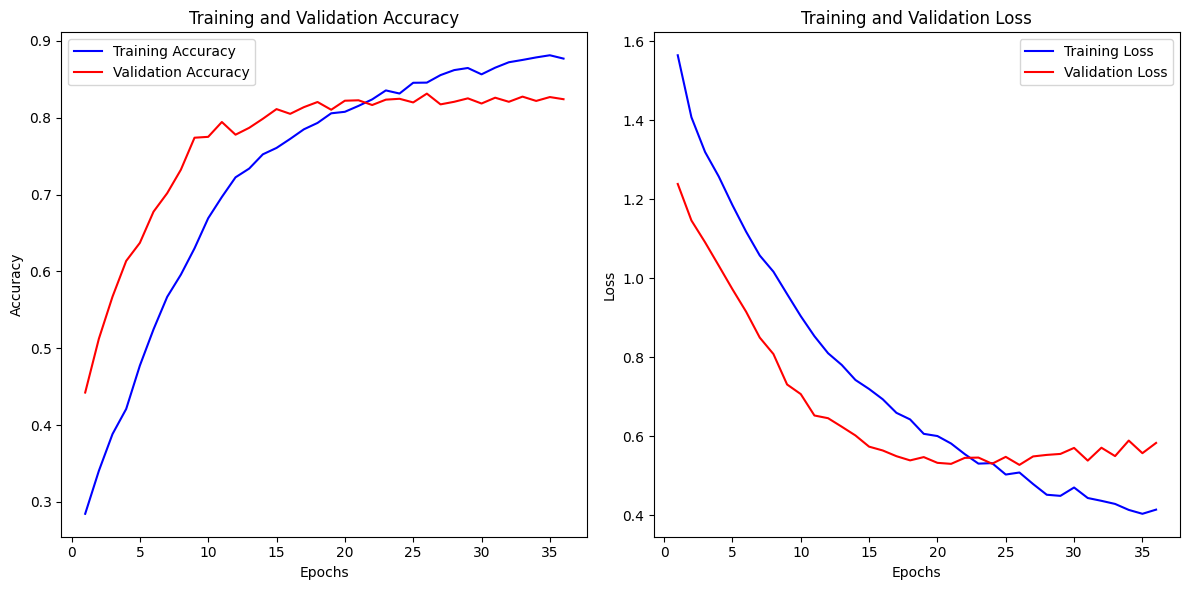

In [21]:
import matplotlib.pyplot as plt

# Get training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range for epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predicted labels for the validation data
true_labels = []
predicted_labels = []

# Iterate through the validation data to get true and predicted labels
for images, labels in val_generator:
    # True labels
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    
    # Predicted labels
    preds = model.predict(images, verbose=0)
    predicted_labels.extend(np.argmax(preds, axis=1))

# Convert to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Class names
class_names = val_generator.class_names  # Inferred from the dataset

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

      broken       0.70      0.66      0.68       249
  discolored       0.72      0.69      0.71       300
        pure       0.75      0.75      0.75       293
     silkcut       0.77      0.82      0.79       278

    accuracy                           0.73      1120
   macro avg       0.73      0.73      0.73      1120
weighted avg       0.73      0.73      0.73      1120



In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset preparation with advanced augmentation
data_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Reduce from 30 to 15 for less distortion
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Slightly reduced
    transforms.RandomAffine(degrees=10),  # Slightly reduce random affine rotation
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])




# Load dataset
full_dataset = datasets.ImageFolder('/kaggle/input/corndatanew/train', transform=data_transform)

# Split into training (80%) and validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained EfficientNet B0
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Move the model to the correct device (GPU/CPU)
model = model.to(device)

# Freeze the backbone layers initially
for param in model.features.parameters():
    param.requires_grad = False

# Get the output size of the last layer before the classifier
dummy_input = torch.randn(1, 3, 227, 227).to(device)  # Ensure this is on the same device as the model
output = model.features(dummy_input)  # Pass a dummy input through the feature extractor
num_features = output.shape[1]  # Get the number of output channels from the last conv layer

# Custom classifier with dynamic input size
model.classifier = nn.Sequential(
    nn.Flatten(),              # Flatten the output of the pooling layer
    nn.Dropout(0.5),           # Dropout to prevent overfitting
    nn.Linear(1280, 256),      # Fully connected layer (1280 -> 256), since EfficientNetB0 output size is 1280
    nn.ReLU(),                 # Activation function
    nn.BatchNorm1d(256),       # Batch normalization
    nn.Dropout(0.3),           # Additional dropout
    nn.Linear(256, 128),       # Another fully connected layer (256 -> 128)
    nn.ReLU(),                 # Activation function
    nn.BatchNorm1d(128),
    nn.Dropout(0.3),
    nn.Linear(128, 64),        # Add layer with 64 neurons (128 -> 64)
    nn.ReLU(),                 # Activation function
    nn.BatchNorm1d(64),        # Batch normalization
    nn.Dropout(0.3),
    nn.Linear(64, 32),         # Add layer with 32 neurons (64 -> 32)
    nn.ReLU(),                 # Activation function
    nn.BatchNorm1d(32),        # Batch normalization
    nn.Dropout(0.3),
    nn.Linear(32, 4)           # Final output layer with 4 classes (32 -> 4)
)

# Move model to the device (GPU or CPU)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=3, threshold=0.01)

# Early stopping parameters
patience = 5  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')  # Start with a very high value
epochs_without_improvement = 0  # Track how many epochs we've waited without improvement

# Training loop
num_epochs = 50
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100. * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100. * val_correct / val_total
    val_loss = val_loss / len(val_loader)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Save the best model
    if val_loss < best_val_loss:  # Check for improvement in validation loss
        best_val_loss = val_loss
        epochs_without_improvement = 0  # Reset counter
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1  # Increment the counter if no improvement

    # Early stopping check
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break  # Stop training if patience is reached

     # Unfreeze the backbone for fine-tuning after the initial epochs
    if epoch > 15:
        for param in model.features.parameters():
            param.requires_grad = True
        optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    

print("Training complete!")


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 114MB/s]


Epoch 1/50, Train Loss: 1.4355, Train Accuracy: 31.26%, Val Loss: 1.2196, Val Accuracy: 45.73%
Epoch 2/50, Train Loss: 1.2752, Train Accuracy: 40.77%, Val Loss: 1.0791, Val Accuracy: 55.33%
Epoch 3/50, Train Loss: 1.1737, Train Accuracy: 47.46%, Val Loss: 1.0007, Val Accuracy: 57.93%
Epoch 4/50, Train Loss: 1.1219, Train Accuracy: 50.66%, Val Loss: 0.9605, Val Accuracy: 59.50%
Epoch 5/50, Train Loss: 1.0785, Train Accuracy: 52.95%, Val Loss: 0.9327, Val Accuracy: 59.95%
Epoch 6/50, Train Loss: 1.0636, Train Accuracy: 53.38%, Val Loss: 0.9098, Val Accuracy: 61.07%
Epoch 7/50, Train Loss: 1.0387, Train Accuracy: 54.83%, Val Loss: 0.8977, Val Accuracy: 63.00%
Epoch 8/50, Train Loss: 1.0298, Train Accuracy: 55.69%, Val Loss: 0.9026, Val Accuracy: 61.46%
Epoch 9/50, Train Loss: 1.0262, Train Accuracy: 55.99%, Val Loss: 0.8874, Val Accuracy: 62.33%
Epoch 10/50, Train Loss: 1.0178, Train Accuracy: 56.25%, Val Loss: 0.8748, Val Accuracy: 63.28%
Epoch 11/50, Train Loss: 1.0041, Train Accuracy: 

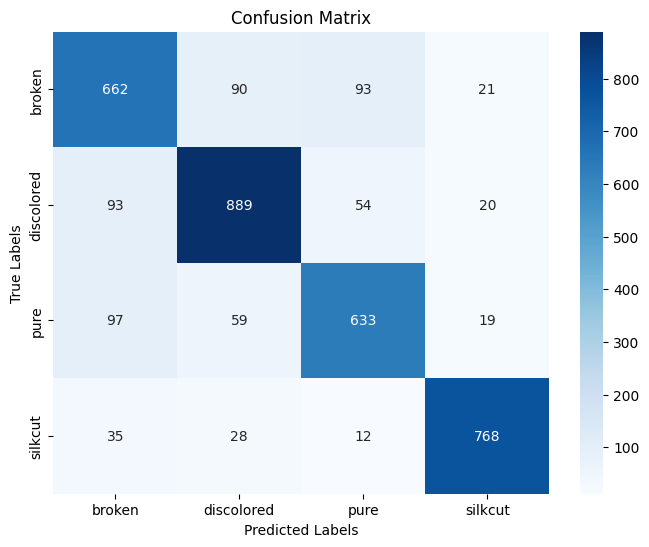

In [15]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming val_loader is your validation DataLoader
# and model is your trained model

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Get the original full dataset (the one passed to ImageFolder)
full_dataset = val_loader.dataset.dataset  # This is the ImageFolder dataset

# Set the model to evaluation mode
model.eval()

# Iterate through the validation data to get true and predicted labels
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # True labels
        true_labels.extend(labels.cpu().numpy())
        
        # Predicted labels
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Class names from the original dataset (ImageFolder)
class_names = full_dataset.classes  # This gets class names from ImageFolder

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn for better visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


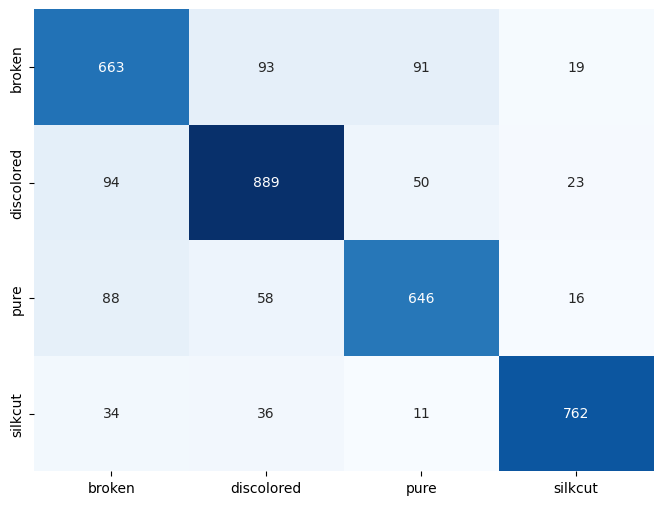

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Assuming val_loader is your validation DataLoader
# and model is your trained model

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Get the original full dataset (the one passed to ImageFolder)
full_dataset = val_loader.dataset.dataset  # This is the ImageFolder dataset

# Set the model to evaluation mode
model.eval()

# Iterate through the validation data to get true and predicted labels
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # True labels
        true_labels.extend(labels.cpu().numpy())
        
        # Predicted labels
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Class names from the original dataset (ImageFolder)
class_names = full_dataset.classes  # This gets class names from ImageFolder

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a DataFrame for the confusion matrix to make it easy to work with
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Create the confusion matrix plot as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar=False)

# Save the plot as an SVG file (editable)
svg_file_path = "confusion_matrix.svg"
plt.savefig(svg_file_path, format="svg")

# Display the plot
plt.show()

